In [18]:
from lsst.daf.butler import Butler
from astropy.table import Table
import pylab
import numpy
from astropy.stats import mad_std
from tqdm import tqdm
from astropy.io import fits
import pandas as pd
from scipy import stats
from multiprocessing import Pool
import pickle
import os

In [19]:
repo_path = "/repo/ir2"
butler = Butler(repo_path,instrument='LSSTCam')
registry = butler.registry

We query what collections we have in the repository

In [20]:
#13590
#13535
#13525
# https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=405094202
collections = list(registry.queryCollections("*stability*13535*"))
collections

['u/lsstccs/eo_flat_gain_stability_13535_w_2023_41/20231112T062559Z',
 'u/lsstccs/eo_flat_gain_stability_13535_w_2023_41']

We query what dataset are in this collections

In [21]:
list(registry.getCollectionSummary(collections[0]).dataset_types)

[DatasetType('flatGainStabilityTask_log', {instrument, detector}, ButlerLogRecords),
 DatasetType('flat_gain_stability_stats', {instrument, detector}, DataFrame),
 DatasetType('flatGainStabilityTask_metadata', {instrument, detector}, TaskMetadata),
 DatasetType('flatGainStabilityPlots_metadata', {instrument}, TaskMetadata),
 DatasetType('flatGainStabilityTask_config', {}, Config),
 DatasetType('flat_gain_stability_plots', {instrument}, Plot),
 DatasetType('flatGainStabilityPlots_config', {}, Config),
 DatasetType('packages', {}, Packages),
 DatasetType('flatGainStabilityPlots_log', {instrument}, ButlerLogRecords)]

We convert the sensor address to the DM numbering

In [22]:
sensor="R23_S00"
detector=list(registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id
detector

99

Obtain flat stability statistics given the sensor

In [23]:
df=butler.get('flat_gain_stability_stats',collections=collections,detector=detector)
df

,raft,slot,exposure,pd_integral,mjd,amp_name,median,stdev_clip
0,R23,S00,2023111001321,0.000002,60259.222765,C10,14685.433594,121.013648
1,R23,S00,2023111001321,0.000002,60259.222765,C11,14696.310547,136.417904
2,R23,S00,2023111001321,0.000002,60259.222765,C12,14790.843750,121.775901
3,R23,S00,2023111001321,0.000002,60259.222765,C13,14686.334961,120.946175
4,R23,S00,2023111001321,0.000002,60259.222765,C14,14729.735352,122.612289
...,...,...,...,...,...,...,...,...
17755,R23,S00,2023111100813,0.000002,60260.262762,C04,14188.246094,115.222155
17756,R23,S00,2023111100813,0.000002,60260.262762,C03,14163.139648,115.512521
17757,R23,S00,2023111100813,0.000002,60260.262762,C02,14160.588867,114.472667
17758,R23,S00,2023111100813,0.000002,60260.262762,C01,14161.702148,114.539916


Specify temp key

In [24]:
TEMPKEY='TEMP6'

Retrieve temperature in fits header more efficient than how butler does. It only asks the first 100kB to read from the disk.

In [28]:
expids=set(list(df['exposure']))

fsspec_kwargs = {
#    "default_block_size": 100000,
    "default_cache_type": "bytes",
    "endpoint_url": "https://s3dfrgw.slac.stanford.edu"
}

def oneprocess(ref):
    print(butler.getURI('raw',dataId={"exposure": ref},
        collections=collections,detector=detector).geturl())
    with fits.open(
        butler.getURI('raw',dataId={"exposure": ref},
        collections=collections,detector=detector).geturl(),
        use_fsspec=True,
        fsspec_kwargs = fsspec_kwargs
         ) as fh:
        proto={
            "exposure": ref,
            "TEMP6": (fh[-2].header["TEMP6"]),
            "TEMP10": (fh[-2].header["TEMP10"])
        }
    return proto


oneprocess(list(expids)[0])

s3://rubin-sts/LSSTCam/20231111/MC_C_20231111_000416/MC_C_20231111_000416_R23_S00.fits


{'exposure': 2023111100416, 'TEMP6': -11.5, 'TEMP10': -11.625}

Merge the table using 'exposure'

In [9]:
dfmerged=pd.merge(df, pd.DataFrame({'exposure': expid, TEMPKEY: temps }), on='exposure', how='inner')

In [10]:
subset=dfmerged[dfmerged['amp_name']=='C00']
y0=(subset['median']/subset['pd_integral']).min()

In [6]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(subset[TEMPKEY],subset['median']/subset['pd_integral']/y0)

NameError: name 'subset' is not defined

Text(0, 0.5, 'median/pd_integral')

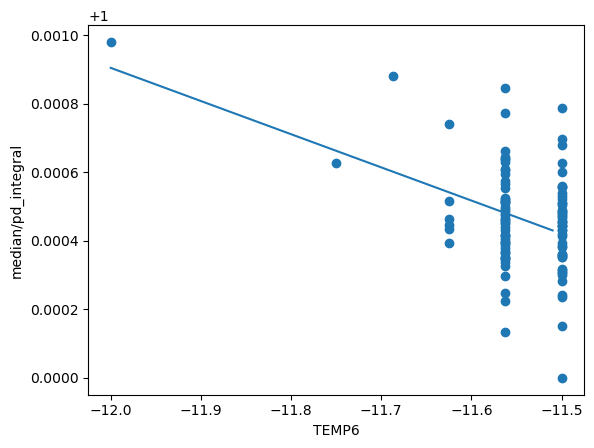

In [12]:
pylab.scatter(subset[TEMPKEY],subset['median']/subset['pd_integral']/y0)
x = numpy.arange( subset[TEMPKEY].min(), subset[TEMPKEY].max(),0.01)
pylab.plot(x, x*slope+intercept,"-")
pylab.xlabel(TEMPKEY)
pylab.ylabel('median/pd_integral')

In [5]:
def getcoef( detector ):
    df=butler.get('flat_gain_stability_stats',collections=collections,detector=detector)

    expids=set(list(df['exposure']))
    
    fsspec_kwargs = {
#        "default_block_size": 100000,
        "default_cache_type": "bytes",
        "endpoint_url": "https://s3dfrgw.slac.stanford.edu"
    }
    
    temps1=[]
    temps2=[]
    expid=[]
    for ref in tqdm(sorted( expids )[::]):
        try:
    
            with fits.open(
                butler.getURI('raw',dataId={"exposure": ref},
                collections=collections,detector=detector).geturl(),
                use_fsspec=True,
                fsspec_kwargs = fsspec_kwargs
                 ) as fh:            
                expid.append(ref)
                temps1.append(fh[-2].header['TEMP6'])
                temps2.append(fh[-2].header['TEMP10'])
    
        except:
            pass

    dfmerged=pd.merge(df, pd.DataFrame({'exposure': expid, 'TEMP6': temps1, 'TEMP10': temps2 }), on='exposure', how='inner')

    ret = {}
    for amp in list(set(dfmerged.amp_name)):
        subset=dfmerged[dfmerged['amp_name']==amp]
        y0=(subset['median']/subset['pd_integral']).min()
        x=(subset['TEMP6']+subset['TEMP10'])/2
        y=subset['median']/subset['pd_integral']/y0
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        ret.update( {amp: { 
            "x": x,
            "y": y,
            "y0": y0,
            "slope": slope,
            "intercept": intercept,
            "r_value": r_value,
            "p_value": p_value,
            "std_err": std_err } })
    return ret

In [ ]:
for did in list(registry.queryDimensionRecords("detector",instrument='LSSTCam')):
    print(did.id, did.full_name)
    path = f'{did.full_name}.pickle'
    if os.path.exists(path):
        continue

    ret={ did.full_name: getcoef(did.id) }
    with open(path,'wb') as f:
        pickle.dump(ret,f)
    

#getcoef('')

0 R01_S00
1 R01_S01
2 R01_S02
3 R01_S10
4 R01_S11
5 R01_S12
6 R01_S20
7 R01_S21
8 R01_S22
9 R02_S00
10 R02_S01
11 R02_S02
12 R02_S10
13 R02_S11
14 R02_S12
15 R02_S20
16 R02_S21
17 R02_S22
18 R03_S00
19 R03_S01
20 R03_S02
21 R03_S10
22 R03_S11
23 R03_S12
24 R03_S20
25 R03_S21
26 R03_S22
27 R10_S00
28 R10_S01
29 R10_S02
30 R10_S10
31 R10_S11
32 R10_S12
33 R10_S20
34 R10_S21
35 R10_S22
36 R11_S00
37 R11_S01
38 R11_S02
39 R11_S10
40 R11_S11
41 R11_S12
42 R11_S20
43 R11_S21
44 R11_S22
45 R12_S00
46 R12_S01
47 R12_S02
48 R12_S10
49 R12_S11
50 R12_S12
51 R12_S20
52 R12_S21
53 R12_S22
54 R13_S00
55 R13_S01
56 R13_S02
57 R13_S10
58 R13_S11
59 R13_S12
60 R13_S20
61 R13_S21
62 R13_S22
63 R14_S00
64 R14_S01
65 R14_S02
66 R14_S10
67 R14_S11
68 R14_S12
69 R14_S20
70 R14_S21
71 R14_S22
72 R20_S00
73 R20_S01
74 R20_S02
75 R20_S10
76 R20_S11
77 R20_S12
78 R20_S20
79 R20_S21
80 R20_S22
81 R21_S00
82 R21_S01
83 R21_S02
84 R21_S10
85 R21_S11
86 R21_S12
87 R21_S20
88 R21_S21
89 R21_S22
90 R22_S00
91 R22_S0

100%|██████████| 1110/1110 [11:21<00:00,  1.63it/s] 


171 R42_S00


100%|██████████| 1110/1110 [10:04<00:00,  1.84it/s]


172 R42_S01


100%|██████████| 1110/1110 [10:28<00:00,  1.76it/s]


173 R42_S02


100%|██████████| 1110/1110 [10:07<00:00,  1.83it/s]


174 R42_S10


100%|██████████| 1110/1110 [10:25<00:00,  1.78it/s]


175 R42_S11


 66%|██████▌   | 735/1110 [07:08<03:52,  1.61it/s]

In [ ]:
pylab.hist([ ret['R01_S01'][x]['y0'] for x in ret['R01_S01'] ])

In [ ]:
pylab.hist([ ret['R01_S01'][x]['slope'] for x in ret['R01_S01'] ])

In [ ]:
import pickle
with open('gaintemp.pickle','wb') as f:
    pickle.dump(ret,f)